# Jacoubet Atlas Challenge - OPER

In [2]:
import numpy as np
import cv2
import os

import skimage
import skimage.io

from skimage.filters import threshold_otsu, gaussian
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from skimage.morphology import remove_small_holes, remove_small_objects, binary_dilation, \
        binary_erosion, binary_closing, square, dilation, erosion, opening, \
        closing, diameter_opening, binary_opening

## Utils 

In [6]:
def load_image(image_path):
    """
    Load image with its path
    """
    return skimage.io.imread(image_path)

plt.rcParams['image.cmap'] = 'gray'
def show_image(img):
    """
    Show a single image
    """
    fig = plt.figure(figsize = (15,10))
    plt.imshow(img)

def show_images(objects, col=5):
    """
    Show a list of images (max 5 columns) = input
    """
    fig = plt.figure(figsize = (14,8))

    length = len(objects)
    
    rows = length // col + 1
    columns = col

    for i in range(length):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(objects[i])
    plt.show()

In [7]:
def create_mark(rectangles, shape): # [((begin_i, begin_j), (end_i, end_j)), ...]
    """
    Using a list of rectangles, create an image of marks
    """
    marked_img = np.zeros(shape = shape, dtype=int)
    for rect in rectangles:
        for j in range(rect[0][1], rect[1][1]):
            for i in range(rect[0][0], rect[1][0]):
                marked_img[j][i][3] = 255
    return marked_img

def apply_marks(origin, marks, inversed=True):
    """
    Extract numbers of the image using the marks
    """
    extract = np.zeros(shape = origin.shape[:2], dtype=bool) # all false = all black
    for i in range(origin.shape[0]):
        for j in range(origin.shape[1]):
            if marks[i][j][3] > 0:
                if inversed and origin[i][j][0] < 240: # if marked and object
                    extract[i][j] = True # set to white
                elif not inversed and origin[i][j][0] > 120:
                    extract[i][j] = True
    return extract

In [8]:
# le disk peut changer en fonction des vrai données
def fill_holes(img, elt = skimage.morphology.disk(1)):
    """
    Closure: to fill holes
    """
    if elt is None:
        return img
    return skimage.morphology.closing(img, elt)

In [9]:
def get_objects(img):
    """
    From an image containing all the objects, return a list of image with a single object
    """
    tmp_img = np.copy(img) # to avoid modifying the original
    
    # list of objects
    objs = []
    
    def get_object(img, obj, i, j):
        # out of bounds
        if j >= img.shape[0] or j < 0:
            return
        if i >= img.shape[1] or i < 0:
            return
        # if objet
        if img[j][i]:
            obj[j][i] = True
            img[j][i] = False
            # recursive calls
            get_object(img, obj, i+1, j)
            get_object(img, obj, i, j+1)
            get_object(img, obj, i-1, j)
            get_object(img, obj, i, j-1)
    
    for j in range(tmp_img.shape[0]):
        for i in range(tmp_img.shape[1]):
            # first cell of object
            if tmp_img[j][i]:
                # create image for object
                obj = np.zeros(shape = tmp_img.shape, dtype=bool)
                # fill the image
                get_object(tmp_img, obj, i, j)
                # add to objects
                objs.append(obj)
                
    return objs

def get_bounding_box(img):
    min_i = img.shape[1]
    max_i = 0
    min_j = img.shape[0]
    max_j = 0
    
    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            if img[j][i]:
                if j > max_j:
                    max_j = j
                if j < min_j:
                    min_j = j
                if i > max_i:
                    max_i = i
                if i < min_i:
                    min_i = i
                    
    return ((min_i, min_j), (max_i + 1, max_j + 1))

def transpose_obj_to_new_object(obj):
    """
    Create a smaller image to contain only to object
    """
    bbox = get_bounding_box(obj)
    shape = (bbox[1][1] - bbox[0][1], bbox[1][0] - bbox[0][0])
    # new image with size = bounding box
    new_obj = np.zeros(shape = shape, dtype=bool)
    
    # transpose
    for j in range(shape[0]):
        for i in range(shape[1]):
            new_obj[j][i] = obj[j + bbox[0][1]][i + bbox[0][0]]

    return new_obj

def transpose_objects(objects):
    """
    Transpose a list of objects
    """
    new_objects = []
    for obj in objects:
        # get object in a smaller image
        new_obj = transpose_obj_to_new_object(obj)
        new_objects.append(new_obj)
    return new_objects

In [10]:
# filtrer: prendre uniquement les images avec un seul nombre (fonctionne uniquement si une majorité de nombres simples)
def extract_single_numbers(images):
    # compute mean of shapes
    shapes = [arr.shape for arr in images]
    mean_shape = np.mean(shapes, axis=0)

    # apply filter
    k = mean_shape / 2
    singles, multiples = [], []
    for obj in images:
        if (mean_shape[0] - k[0] <= obj.shape[0] and obj.shape[0] <= mean_shape[0] + k[0] and mean_shape[1] - k[1] <= obj.shape[1] and obj.shape[1] <= mean_shape[1] + k[1]):
            singles.append(obj)
        else:
            multiples.append(obj)
            
    return singles, multiples

In [11]:
def turn_image(img): # turn if 3/4 * x > y
    if img.shape[0] < img.shape[1] * 0.75:
        return img[::-1].T # -90 degré # comment faire pour le sens ?
    return img

def turn_images(images):
    new_imgs = []
    for img in images:
        new_imgs.append(turn_image(img))
    return new_imgs

In [12]:
# remove all black and almost all white objects
def filter_images(objects):
    objects_white = [pixels for pixels in objects if np.any(pixels)]
    real_objects = []
    for obj in objects_white:
        nb_zeros = np.count_nonzero(obj)
        nb_pixels = obj.shape[0] * obj.shape[1]
        if nb_zeros / nb_pixels < 0.65:
            real_objects.append(obj)
    return real_objects

## Preprocessing

In [45]:
from skimage.measure import label, regionprops

def filter_small_objects(small, denoised, binary_otsu):
    label_image = label(small)

    for i, region in enumerate(regionprops(label_image)):
        bbox = region.bbox
        ratio = region.minor_axis_length / region.major_axis_length
        box = label_image[bbox[0]:bbox[2],bbox[1]:bbox[3]]

        if ratio < 0.25:
            sm = small[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            sm[box == i + 1] = 0
            continue

        labeled = denoised[bbox[0]:bbox[2],bbox[1]:bbox[3]][box == i + 1]

        total_count = labeled.shape[0]
        black_count = np.sum(labeled <= 0.5)# - total_count / 3

        total_square_count = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        active_square_count = np.sum(box == i + 1)

        if black_count / total_count < 0.1 or active_square_count / total_square_count < 0.2:
            sm = small[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            sm[box == i + 1] = 0
            continue
            
    closed_small = dilation(small, square(30))
        
    im = (binary_otsu*255 - small) > 0
    closed_small[im > 0] = False
    closed_small = closed_small > 0
    closed_small = remove_small_holes(closed_small, 1000)

    closed_small = remove_small_objects(closed_small, 1000)*255 - remove_small_objects(closed_small, 10000)*255
    
    label_image = label(closed_small)

    for i, region in enumerate(regionprops(label_image)):
        bbox = region.bbox
        box = label_image[bbox[0]:bbox[2],bbox[1]:bbox[3]]

        ratio = region.minor_axis_length / region.major_axis_length

        if ratio < 0.4:
            sm = closed_small[bbox[0]:bbox[2],bbox[1]:bbox[3]]
            sm[box == i + 1] = 0
            
    return np.bitwise_and(closed_small > 0, small > 0)

In [46]:
def get_striped_areas(img):
    gray = rgb2gray(img)

    gauss = (gaussian(gray, 6) * 255).astype(np.uint8)
    threshold = threshold_otsu(gauss)
    binary_otsu = binary_opening(gauss < threshold, selem=skimage.morphology.disk(15))

    return remove_small_objects(binary_otsu, min_size=2000) > 0

In [162]:
from skimage.filters import threshold_otsu, threshold_sauvola, inverse

def preprocess(image):
    denoised = rgb2gray(cv2.fastNlMeansDenoising(image))
    gray = 1 - denoised

    threshold = threshold_otsu(gray)
    binary_otsu = binary_dilation(gray > threshold)
    
    gray = 1 - rgb2gray(denoised)

    threshold = threshold_sauvola(gray, window_size=25, k=0.05)
    binary = gray > threshold
    binary = binary * 255 - remove_small_objects(binary, 400) * 255
    binary = binary > 0
    
    small = (remove_small_objects(binary, 5) * 255) - (remove_small_objects(binary, 400) * 255)
    
    filtered_small = filter_small_objects(small, denoised, binary_otsu)
    
    return filtered_small


## Segmentation

In [218]:
def segment_characters(img, marked=None, elt = skimage.morphology.disk(1), inversed=True):
    """
    From the original image, the marks and the structural element for closure,
    return and show the resulting objects in image
    """
    if marked is not None:
        extracted = apply_marks(img, marked, inversed)
    else:
        extracted = img
    closed = fill_holes(extracted, elt)
    objects = get_objects(closed)
    new_objects = transpose_objects(objects)
    real_objects = filter_images(new_objects)
    singles, multiples = extract_single_numbers(real_objects)
    turned = turn_images(singles) # not necessary
    turned.extend(multiples)

    return turned

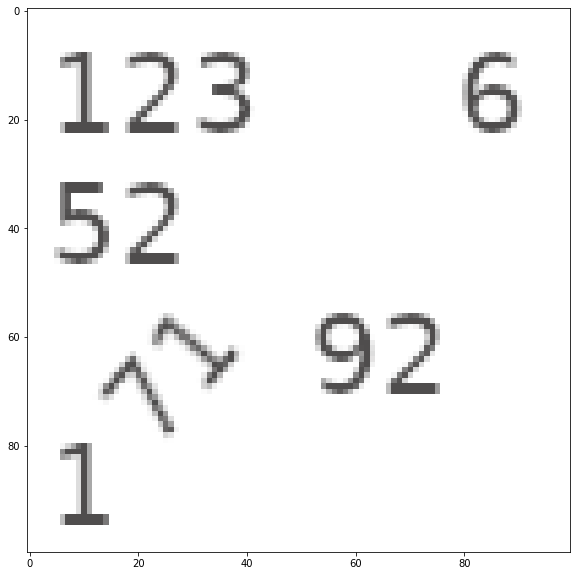

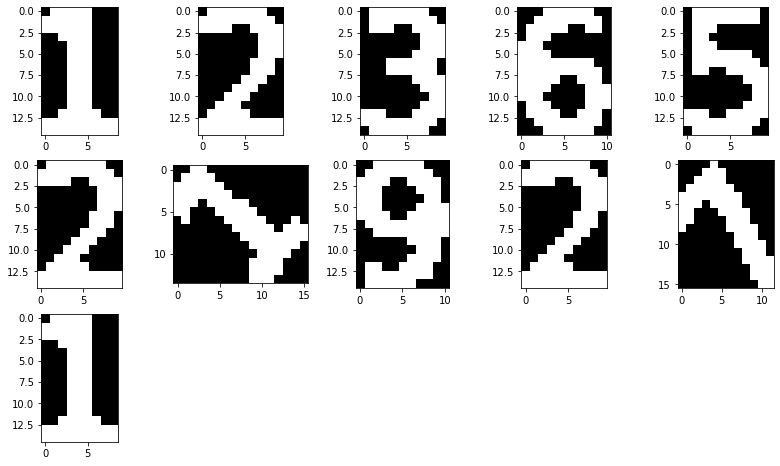

In [219]:
original = load_image("images/all-numbers.png")
show_image(original)
rectangles = [
    (
        (3, 5), (42, 25)
    ),
    (
        (78, 5), (95, 25)
    ),
    (
        (3, 30), (30, 47)
    ),
    (
        (3, 77), (17, 95)
    ),
    (
        (15, 55), (42, 80)
    ),
    (
        (53, 55), (78, 73)
    )
]
marked = create_mark(rectangles, original.shape)
n1 = segment_characters(original, marked, skimage.morphology.disk(1))
show_images(n1)

## Character Recognition 

## The OPER algorithm 

In [298]:
import os

def process_atlas(atlas_path, csv_writer):
    """
    Compute the detection and analysis of street numbers in an atlas, and write it to csv.
    """
    atlas_id = os.path.splitext(os.path.basename(atlas_path))[0]
    image = skimage.io.imread(atlas_path)
    
    # Reduce image size for testing purposes
    image = image[5000:6200, 200: 2000, :]
    
    height, width = image.shape[:2]

    preprocessed_image = preprocess(image)
    show_image(preprocessed_image)

    # Dummy characters which were found by a great algorithm
    characters = ["1", "7", "69", "420"]
    
    for y in range(0, height, 100):
        for x in range(0, width, 100):
            tile_id = f'{atlas_id}_{x}_{y}'
            
            x_end = x + 100 if x + 100 < width else width
            y_end = y + 100 if y + 100 < height else height

            # Apply segmentation and OCR to 100x100 tile of atlas
            #segmentations = segment_characters(preprocessed_image[y:y_end, x:x_end])
            
            csv_writer.writerows([[tile_id] + [' '.join(characters)]])


## Run the algorithm

Let's run all these pieces together shall we ?

In [4]:
FILES = !ls inputs/*

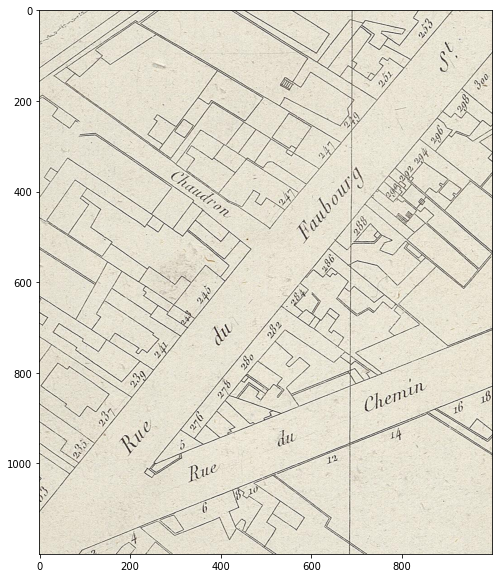

In [276]:
#image = skimage.io.imread(FILES[-1])
image = skimage.io.imread(FILES[3])[5000:6200, 1000: 2000, :]
#image = skimage.io.imread(FILES[-1])[6200:7700, 4600: 6100, :]
# image = skimage.io.imread(FILES[2])[4000:5000, 2000:3000, :]

show_image(image)

/home/mattrouss/EPITA/ING2/IGN/jacoubet/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  # Remove the CWD from sys.path while we load stuff.
/home/mattrouss/EPITA/ING2/IGN/jacoubet/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mattrouss/EPITA/ING2/IGN/jacoubet/env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mattrouss/EPITA/ING2/IGN/jacoubet/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mattrouss/EPITA/ING2/IGN/jacoubet/env/lib/python3.7/sit

/home/mattrouss/EPITA/ING2/IGN/jacoubet/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mattrouss/EPITA/ING2/IGN/jacoubet/env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


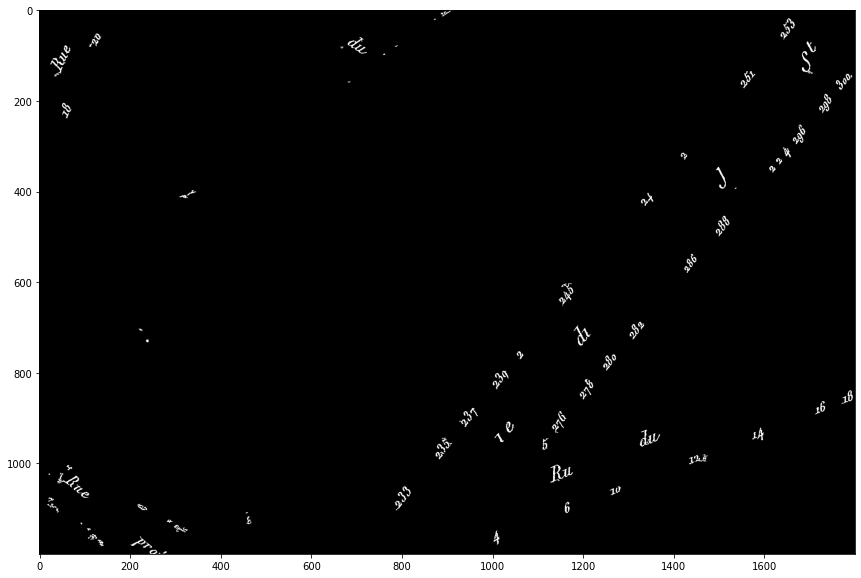

In [299]:
import csv

CSV_OUT_PATH = 'submission_oper.csv'

with open(CSV_OUT_PATH, 'w') as file:
    csv_writer = csv.writer(file)
    for atlas_path in FILES[3:4]:
        process_atlas(atlas_path, csv_writer)

## Testing

You can use this space to test some things ! 

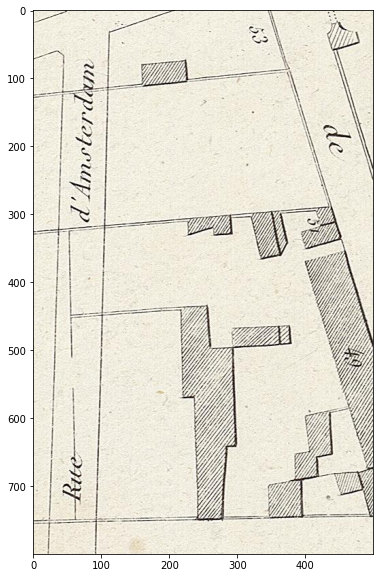

In [18]:
#image = skimage.io.imread(FILES[0])
image = skimage.io.imread(FILES[0])[5500:6300, 2000:2500, :]

show_image(image)

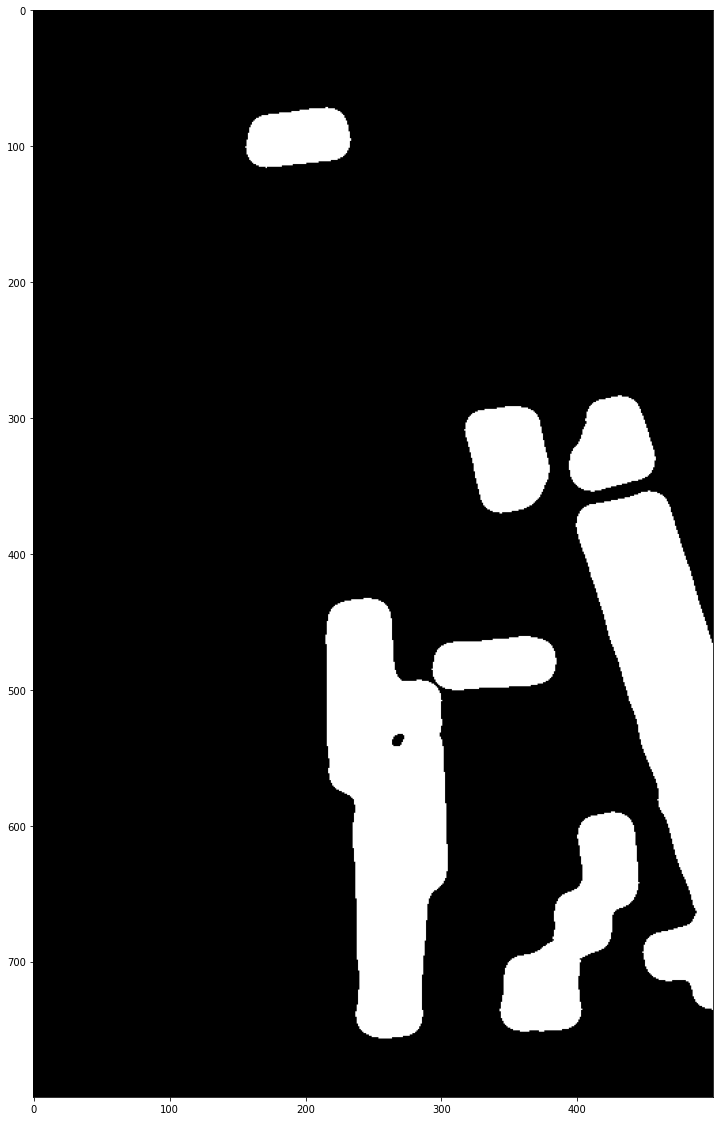

In [47]:
from skimage.filters import gaussian


plt.figure(figsize=(20, 20))
plt.imshow(get_striped_areas(image), cmap=plt.cm.gray)